# Mode Cleaner design notebook
Calculate the transmission of the mode cleaner (MC), find the ideal parameters of the cavity (Length, Finesse, RoC) and calculate the losses and characteristics of the circulating beam.

The geometric & optical length are defined as in the thesis of Eleonora Polini (p209).

In [1]:
# import the required libraries

import matplotlib.pyplot as plt
import numpy as np
import MC_design_functions as MCdf
import sys
plt.style.use('ggplot')

c = 2.99792e8 # Speed of light
lambda_ = 1064e-9 # Carrier wavelength (m)
idxn = 1.44963 # Index of the cavity
SB_limit = 0.90  # SBs transmissions limit
fm = [6.270777e6, 6.270777e6 * 9]  # List of the SBs frequency
P_HOMs = [np.ones(10), np.full(10, 2), np.full(10, 2)]  # Input power of carrier & SBs HOMs

## General tests

Plot a two-mirror Fabry–Perot cavity reflection transfer function and a PDH readout signal.

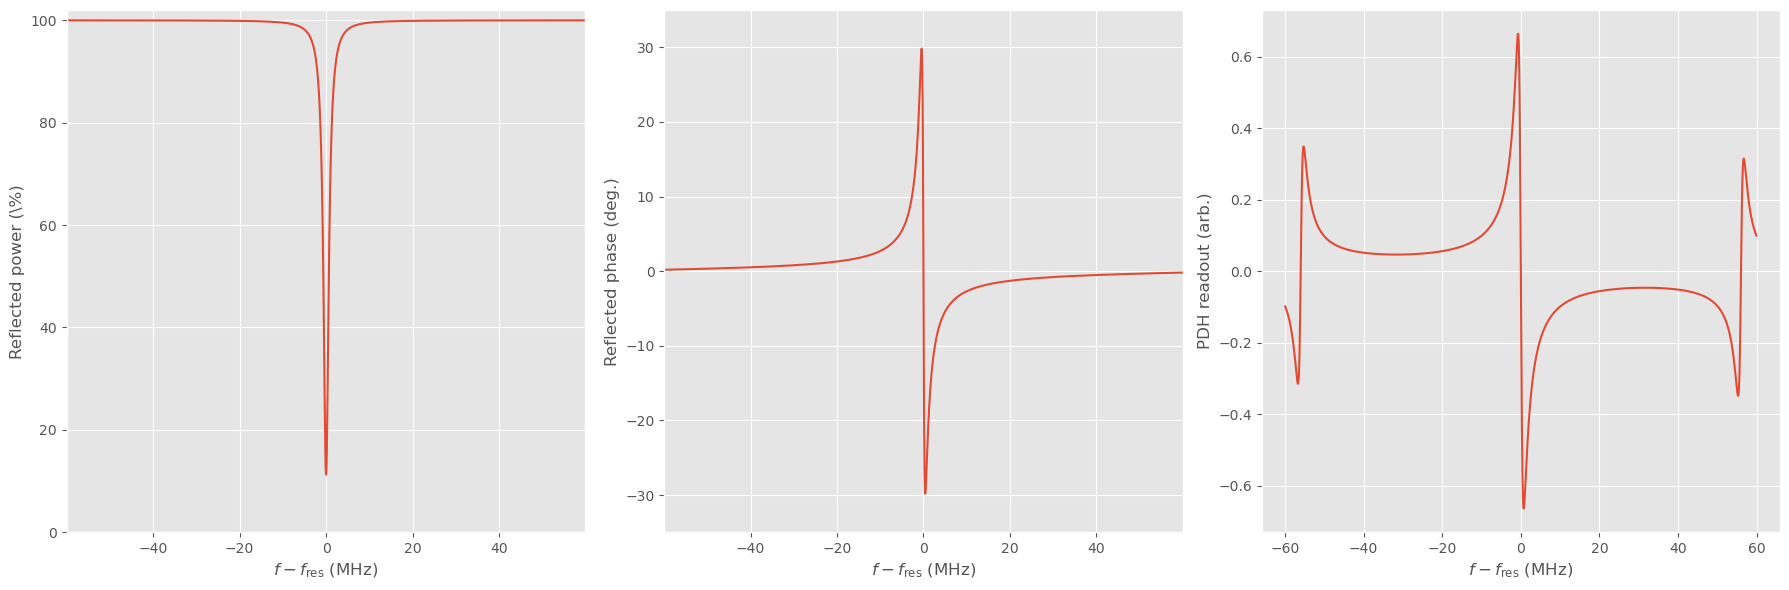

In [2]:
# Call the function with the desired parameters
L = 1.  # length of the optical cavity
r1 = .99  # input mirror reflectivity
r2 = .98  # end mirror reflectivity

f, R, pdh, fsr = MCdf.PDH(L, 56e6,r1,r2)

# Set up subplots and plot the results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot Reflected power
axes[0].plot(f/1e6, 100*np.abs(R)**2)
axes[0].axis([-.4*fsr/1e6, .4*fsr/1e6, 0, 102])
axes[0].set_ylabel('Reflected power (\%)')
axes[0].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

# Plot Reflected phase
axes[1].plot(f/1e6, 180*np.angle(R)/np.pi)
axes[1].axis([-.4*fsr/1e6, .4*fsr/1e6, -35, 35])
axes[1].set_ylabel('Reflected phase (deg.)')
axes[1].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

# Plot PDH readout
axes[2].plot(f/1e6, np.imag(pdh))
axes[2].set_ylabel('PDH readout (arb.)')
axes[2].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

plt.tight_layout()  # Adjust the layout to avoid overlapping
plt.show()

Determine the parameters intervals of a mode cleaner cavity (cf VIR-NOT-071A-08).

In [3]:
# Constants
f = c / lambda_ # Carrier frequency (Hz)
R1 = 0.99; T1=np.sqrt(1-R1) # mirror 1
R2 = 0.99; T2=np.sqrt(1-R2) # mirror 2
TEM_limit = 0.01 # Sidebands & HOMs transmissions limits
Lopt_lim, F_lim, RoC_lim = [1.5e-2, 30e-2], [5, 500], [0,0] # Parameters limits
nm_max = 10 # Number of HOMs to consider
FLopt_lim=[0,0]; RLgeo_lim=[0,0]
k=2*np.pi*f/c

print("-----Parameters intervals-----")
# Losses limitations
losses_max=1/100; P=30/1000000 # P being the loss per face
if np.pi*losses_max/(4*P)<F_lim[1]: F_lim[1]=np.pi*losses_max/(4*P)
print(round(F_lim[0],4),"<F<",round(F_lim[1],4))

# Sidebands transmission
FLopt_lim[1]=np.sqrt(((1-SB_limit)*c**2)/(16*SB_limit*fm[1]**2))
Lopt_lim[1]=FLopt_lim[1]/F_lim[0]
print(round(Lopt_lim[0]*1e2,4),"<Lopt (cm)<",round(Lopt_lim[1]*1e2,4)) # Lopt being the optical length of a one way trip

# Filtering of higher modes
RLgeo_lim[1]=TEM_limit*(2*FLopt_lim[1]/(idxn*np.pi))**2
RoC_lim[0]=RLgeo_lim[1]/(0.5*Lopt_lim[1]/idxn); RoC_lim[1]=RLgeo_lim[1]/(0.5*Lopt_lim[0]/idxn) # Since Lopt=2*Lgeo*n
print(round(RoC_lim[0]*1e2,4),"<RoC (cm)<",round(RoC_lim[1]*1e2,4))

-----Parameters intervals-----
5 <F< 261.7994
1.5 <Lopt (cm)< 8.8533
1.2376 <RoC (cm)< 7.3045


**The length & RoC needs to be smaller than the one used in the OMC (RoC of 780mm, from VIR-0319A-12).** Loop on the parameters to find the best ones (i.e. the ones giving the minimal HOMs transmissions).

In [4]:
precisions=[1e-1, 1e-3, 1e-3] # Precisions on F, Lopt (m), and r (m)
T=[[],[]]; Tbefore=[[1]*len(fm),[1]*nm_max]

for F in np.arange(F_lim[0],F_lim[1],precisions[0]): # Scan on the finesse
  FLopt_max=(c*np.sqrt(1-SB_limit))/(4*fm[-1]*np.sqrt(SB_limit)) # Making sure that we respect the condition on FL
  Lopt_max=min(FLopt_max/F, Lopt_lim[1])
    
  for Lopt in np.arange(Lopt_lim[0], Lopt_max, precisions[1]): # Scan on the length
    Lgeo=(0.5*Lopt/idxn)
    RLgeo_max=TEM_limit*(2*F*Lopt/(idxn*np.pi))**2 # Making sure that we respect the condition on RoCL
    RoC_max = min(RLgeo_max / Lgeo, RoC_lim[1])
    
    for RoC in np.arange(max(RoC_lim[0],Lgeo), RoC_max, precisions[2]): # Scan on the RoC
        for i in range(len(fm)):
            T[0].append(MCdf.Trans_factor(Lgeo, F, RoC, fm[i], 0)) # Transmissions of SB
        for i in range(1,nm_max+1):
            T[1].append(MCdf.Trans_factor(Lgeo, F, RoC, 0, i)) # Transmissions of TEM modes
        if T[0][-1]>=TEM_limit:
          if sum(T[1])<sum(Tbefore[1]):
            Parameters=[F,Lopt,RoC] # if the parameters respects the conditions & allow a lower transmissions of the HOMs we keep them
            Tparameters=T
            Tbefore=T
        T=[[],[]]

print("-----Parameters-----")
print("Geometric length (cm)=", (0.5*Parameters[1]/idxn)*1e2)
print("Finesse=", Parameters[0])
print("RoC (m)=",Parameters[2])

c:\Users\amy\My Drive\Documents\Études\Université\Master 2\Stage\Virgo_AMC_design\MC_design_functions.py:15: RuntimeWarning: invalid value encountered in sqrt
  T=1/(1+(2*Fomc/np.pi)**2*np.sin((2*np.pi*Lopt*freq/c)-N*np.arccos(np.sqrt(1-(2*Lgeo/RoC))))**2)


-----Parameters-----
Geometric length (cm)= 0.517373398729331
Finesse= 29.499999999999915
RoC (m)= 0.018375934580658608


**The optimal length in this case is always the smaller one.** We also need to fix a length compatible with the resonnant conditions of the carrier. Then calculate the transmissions of the SBs & HOMs and plot them.

In [5]:
# Find resonnant length for the carrier transmission
g = 1-((0.5*Parameters[1]/idxn)/Parameters[2]) # g=1-L/RoC
Parameters[1] = MCdf.get_lengths(Parameters[1], lambda_, g)
Lgeo=(0.5*Parameters[1]/idxn)
g = 1-(Lgeo/Parameters[2])

print("Resonnant geometric length (cm)=", Lgeo*1e2)
print()

# Transmissions
T = [MCdf.Trans_factor(Lgeo, Parameters[0], Parameters[2], freq, 0) for freq in fm] # of the SBs
TEM = [MCdf.Trans_factor(Lgeo, Parameters[0], Parameters[2], 0, N) for N in range(nm_max + 1)] # of the HOMs
df = np.arccos(np.sqrt(g)) * c / (2 * np.pi * Parameters[1]) # frequency difference between HOMs (due to the Gouy phase)

print("-----Transmissions-----")
print("SBs transmissions:",T)
print("HOMs transmissions:",TEM)
print("df (MHz)=", df/1e6)


Resonnant geometric length (cm)= 0.5173768725883401

-----Transmissions-----
SBs transmissions: [0.9986311384003848, 0.9000752095918503]
HOMs transmissions: [1.0, 0.005009875363834702, 0.0028728918169693956, 0.008928670420667653, 0.04326581298018526, 0.003550742575203236, 0.003275849870723205, 0.024521364327995204, 0.011918077967560453, 0.0029629245732878257, 0.004340878582863201]
df (MHz)= 1779.140130219498


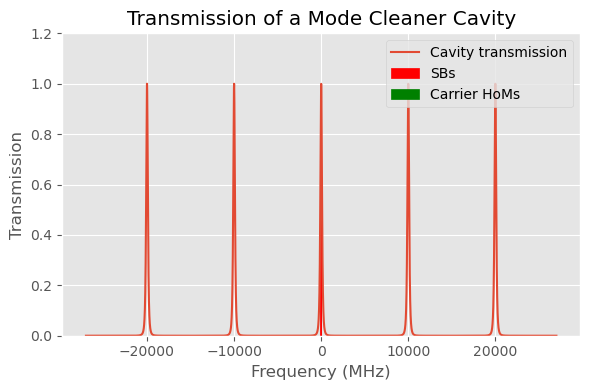

In [6]:
# Transmission of the cavity

plt.figure(figsize=(6, 4))
MCdf.plot_transmission(Lgeo, Parameters[0], Parameters[2], fm, nm_max, plt.gca()) # Calculate the transmissions etc & plot the output of the MC
plt.tight_layout()
plt.show()

**These parameters seems to follow the conditions we imposed on the transmissions. But the length of the cavity is too small to be feasable, and we also need to take into account the HOMs of the SBs.**

Plot the astigmatism losses

c:\Users\amy\My Drive\Documents\Études\Université\Master 2\Stage\Virgo_AMC_design\MC_design_functions.py:50: RuntimeWarning: invalid value encountered in sqrt
  interface_losses=(np.sqrt((1-np.sin(theta)**2)/(1-idxn**2*np.sin(theta)**2))-1)**2


48.32284948698759


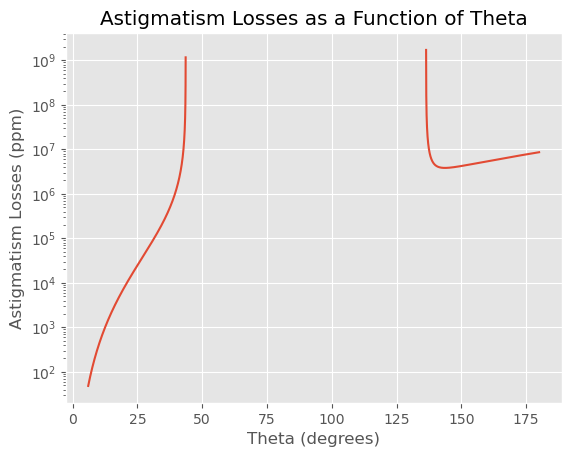

In [7]:
# Astigmatism losses

# Define the parameters for the plot
RoC = 780e-3
Lgeo = MCdf.Lgeo_cavity(0.061315, 0.026068)
Lopt= 2*idxn*Lgeo
theta_min = np.deg2rad(6)
theta_max = np.pi
num_points = 10000

# Create an array of angles (theta) in radians
theta_values = np.linspace(theta_min, theta_max, num_points)

# Calculate astigmatism_losses for each theta value and convert to ppm
astigmatism_losses_values = [MCdf.astigmatism_losses(theta, RoC, Lgeo) * 1e6 for theta in theta_values]

print(MCdf.astigmatism_losses(np.deg2rad(6), RoC, Lgeo)*1e6)

# Plot the results
plt.plot(np.rad2deg(theta_values), astigmatism_losses_values)
plt.xlabel("Theta (degrees)")
plt.ylabel("Astigmatism Losses (ppm)")
plt.yscale('log')
plt.title("Astigmatism Losses as a Function of Theta")
plt.show()

**The formula used is a valid approximation for small angles. With an angle of 6° we get 48ppm, which is the losses for the OMC (VIR-0319A-12).**

## HOMs transmissions

### Heatmap of the HOMs transmissions

We need to specify a minimum feasable width of the cavity (15mm).

Progress: 100.00%
Calculation done.


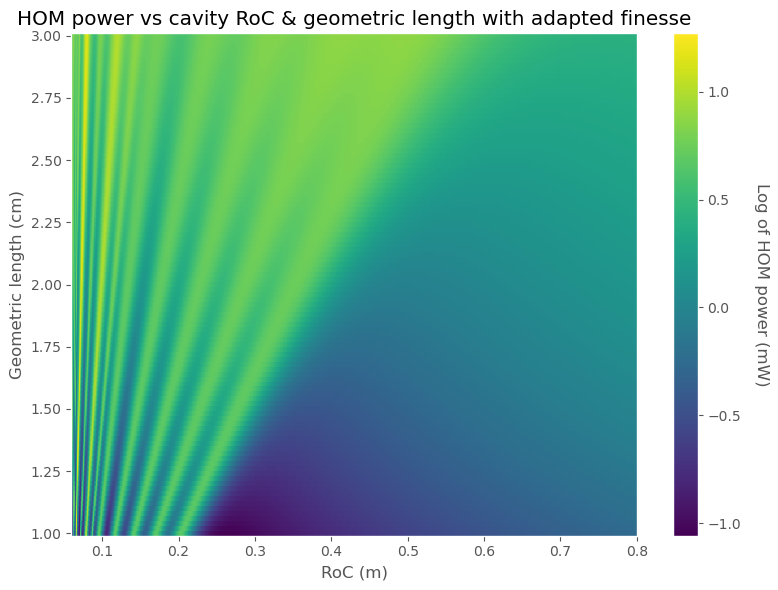

In [8]:
# Heatmap of the HOMs transmissions

# Create a grid of geometric lengths
Lgeo_vect = np.linspace(1e-2, 3e-2, 101) # cm

# Initialize T_HOMs matrices for carrier and SBs
T_HOMs_mat_car = np.zeros((len(Lgeo_vect), 1001))
T_HOMs_mat_SB = np.zeros((len(Lgeo_vect), 1001))

# Loop over geometric lengths and calculate T_HOMs
for j, Lgeo in enumerate(Lgeo_vect):
    # Determine the max finesse that respect SB_limit
    FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
    Lopt=2*idxn*Lgeo
    Fomc = FLopt_max / Lopt
    rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB = MCdf.THOMvsRoC(Lgeo, Fomc, 0.8, fm, P_HOMs, 1001)
    T_HOMs_mat_car[j, :] = T_HOMs_vect_car
    T_HOMs_mat_SB[j, :] = T_HOMs_vect_SB[0]+T_HOMs_vect_SB[1] # Transpose the result to match dimensions
    
    # Print percentage of completion
    sys.stdout.write("\rProgress: {0:.2f}%".format((j+1)/len(Lgeo_vect)*100))
    sys.stdout.flush()

# After the loop
print("\nCalculation done.")

# Plot the heatmaps
plt.figure(figsize=(8, 6))

c1 = plt.pcolormesh(rho_vect, Lgeo_vect*100, np.log10(T_HOMs_mat_car+T_HOMs_mat_SB), cmap='viridis')
plt.xlabel('RoC (m)')
plt.ylabel('Geometric length (cm)')
plt.title('HOM power vs cavity RoC & geometric length with adapted finesse')
colorbar=plt.colorbar(c1)
colorbar.set_label('Log of HOM power (mW)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

**The ideal length seems to be around 1.55cm.**

### HOMs transmissions with fixed lengths

In [9]:
# Input parameters
length_divisors = [2, 4, 6, 8]
results = []

for divisor in length_divisors:
    Lgeo = MCdf.Lgeo_cavity(0.061315/divisor, 0.026068)  
    Lopt = 2*idxn*Lgeo  
    FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
    Fomc = FLopt_max / Lopt
    RoC_max = 1.6/divisor
    rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB = MCdf.THOMvsRoC(Lgeo, Fomc, RoC_max, fm, P_HOMs, 10001)
    T_HOMs_vect_sum = T_HOMs_vect_car + T_HOMs_vect_SB[0] + T_HOMs_vect_SB[1]
    r = rho_vect[np.argmin(T_HOMs_vect_sum)]
    waist = MCdf.waist_size(Lgeo, r, lambda_)
    max_pwr = MCdf.circ_power(1.0, waist)
    print(f"Length (cm): Geometric (divisor={divisor})= ", Lgeo * 10 ** 2, ", physical= ", (0.061315/divisor)*1e2)
    print("Finesse: ", Fomc)
    print("Ideal RoC (m): ", r)
    print("Waist size (μm):", waist*1e6)
    print("Circ power (MW/m²):", max_pwr/1e6) # Supposing an input of 1W
    print()
    results.append((rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB, T_HOMs_vect_sum, Lgeo))



Length (cm): Geometric (divisor=2)=  3.1985336251765397 , physical=  3.06575
Finesse:  4.773499074834663
Ideal RoC (m):  0.8
Waist size (μm): 707.3529599561481
Circ power (MW/m²): 1.9986081294914484

Length (cm): Geometric (divisor=4)=  1.7724888562469114 , physical=  1.532875
Finesse:  8.613987753320396
Ideal RoC (m):  0.4
Waist size (μm): 511.9881219919733
Circ power (MW/m²): 3.81487426789672

Length (cm): Geometric (divisor=6)=  1.3390835101048029 , physical=  1.0219166666666666
Finesse:  11.401975444692626
Ideal RoC (m):  0.04055106899916241
Waist size (μm): 210.42887109158784
Circ power (MW/m²): 22.583401172390293

Length (cm): Geometric (divisor=8)=  1.1392409059925097 , physical=  0.7664375
Finesse:  13.402079595540926
Ideal RoC (m):  0.03451646316031611
Waist size (μm): 194.1638104339139
Circ power (MW/m²): 26.52549073190221



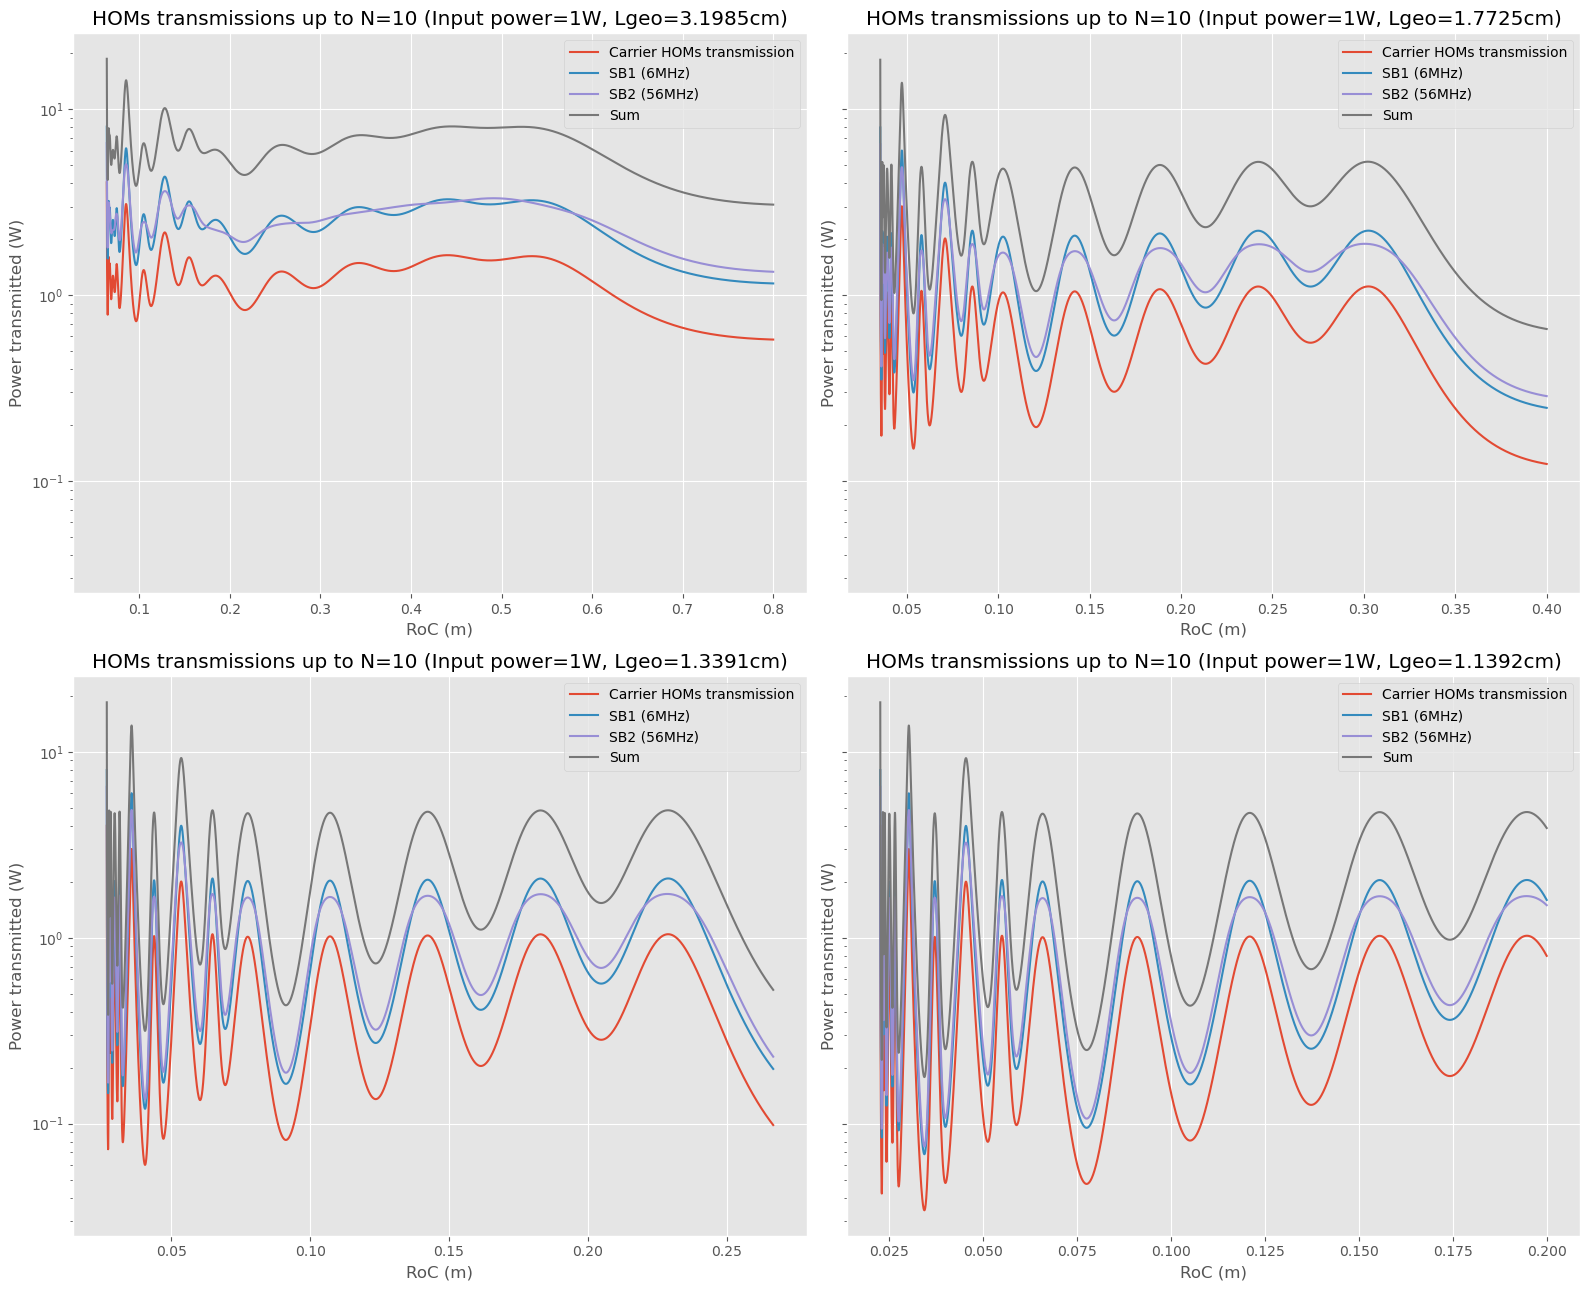

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 13), sharex=False, sharey=True)
axes = axes.flatten()

for i, (rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB, T_HOMs_vect_sum, Lgeo) in enumerate(results):
    ax = axes[i]
    ax.plot(rho_vect, T_HOMs_vect_car, label='Carrier HOMs transmission')
    ax.plot(rho_vect, T_HOMs_vect_SB[0], label='SB1 (6MHz)')
    ax.plot(rho_vect, T_HOMs_vect_SB[1], label='SB2 (56MHz)')
    ax.plot(rho_vect, T_HOMs_vect_sum, label='Sum')
    ax.set_xlabel('RoC (m)')
    ax.set_ylabel('Power transmitted (W)')
    ax.set_yscale('log')
    ax.set_title(f'HOMs transmissions up to N=10 (Input power=1W, Lgeo={round((Lgeo)*1e2,4)}cm)')
    ax.legend()

plt.tight_layout()
plt.show()


**The best RoC seems to be the one after the oscillations of the T_HOMs, due to the HOMs.** With more HOMs we should get a different answer.

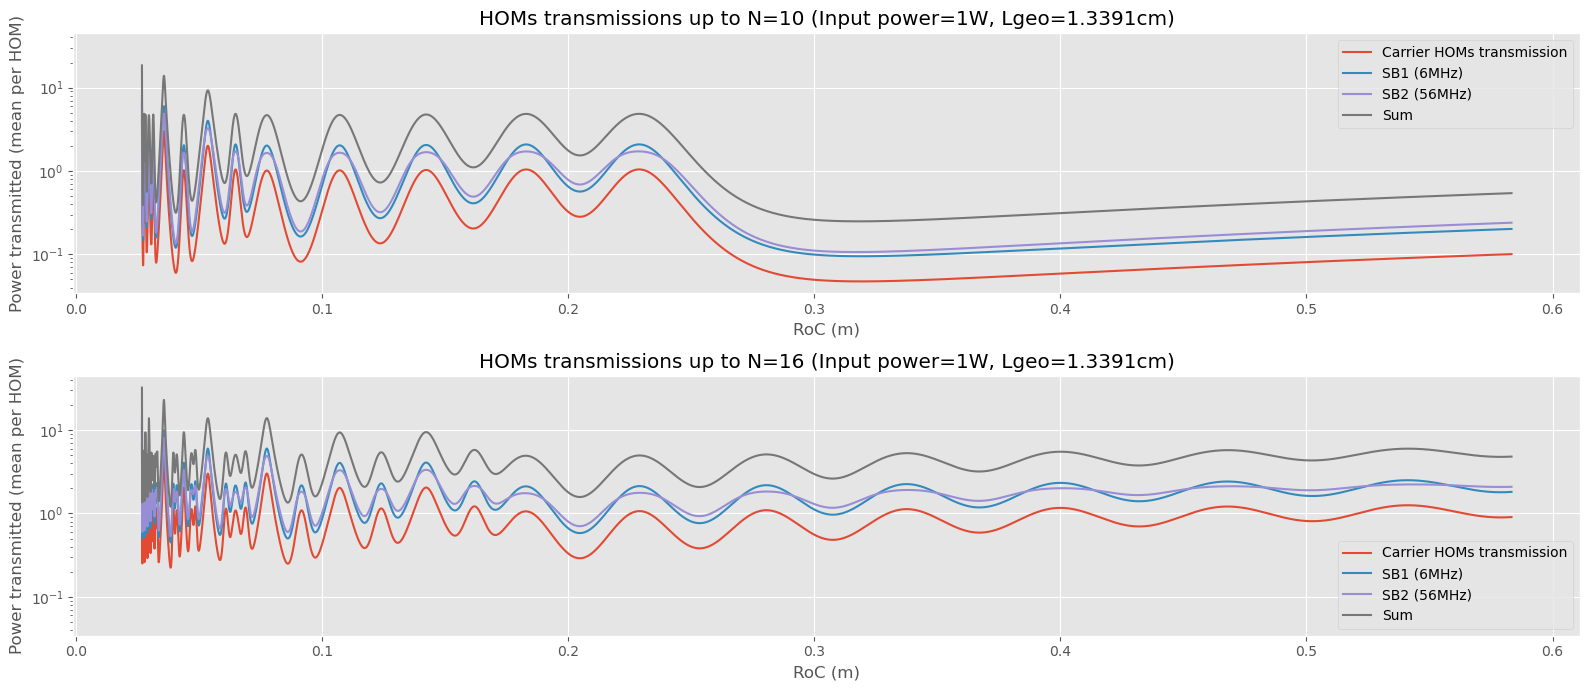

In [12]:
# Input parameters
nHOMs=[10, 16]

fig, axes = plt.subplots(2, 1, figsize=(16, 7), sharex=False, sharey=True)
axes = axes.flatten()

Lgeo = MCdf.Lgeo_cavity(0.061315/6, 0.026068)  # Geometric length of the cavity
Lopt = 2 * idxn * Lgeo  # Optical length travelled by the beam in the cavity

# Determine the max finesse that respect SB_limit
FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
Fomc = FLopt_max / Lopt

# Call the function with the input parameters
RoC_max=3.5/6


for i, n in enumerate(nHOMs):
    P_HOMs = [np.ones(n), np.full(n, 2), np.full(n, 2)]  # Input power of carrier & SBs HOMs
    rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB = MCdf.THOMvsRoC(Lgeo, Fomc, RoC_max, fm, P_HOMs, 10001)

    # Calculate  the total transmissions of the HOMs & the ideal RoC
    T_HOMs_vect_sum = T_HOMs_vect_car + T_HOMs_vect_SB[0] + T_HOMs_vect_SB[1]
    r = rho_vect[np.argmin(T_HOMs_vect_sum)]
    g=1-Lgeo/r

    ax = axes[i]
    ax.plot(rho_vect, T_HOMs_vect_car, label='Carrier HOMs transmission')
    ax.plot(rho_vect, T_HOMs_vect_SB[0], label='SB1 (6MHz)')
    ax.plot(rho_vect, T_HOMs_vect_SB[1], label='SB2 (56MHz)')
    ax.plot(rho_vect, T_HOMs_vect_sum, label='Sum')
    ax.set_xlabel('RoC (m)')
    ax.set_ylabel('Power transmitted (mean per HOM)')
    ax.set_yscale('log')
    ax.set_title(f'HOMs transmissions up to N={n} (Input power=1W, Lgeo={round((Lgeo)*1e2,4)}cm)')
    ax.legend()

plt.tight_layout()
plt.show()


**We need to take the input power of each HOMs to choose the best RoC, and the astigmatism losses to choose the AoI (angle of incidence).**

## Studies with a 1.55cm cavity

**The best compromise seems to be 1.55cm.** We should investigate more on this design, notably by taking a RoC around 10cm.

In [13]:
# Characteristics & losses estimations

cavity_dim=[[0.06200/4],[15e-3]] # Fixed physical lengths & width of the cavity
Lgeo=MCdf.Lgeo_cavity(cavity_dim[0][0], cavity_dim[1][0]) # Compute the geometric length of the cavity
Lopt=2 * idxn * Lgeo

FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit)) # Determine the max finesse that respect SB_limit
Fomc=FLopt_max / Lopt

rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB = MCdf.THOMvsRoC(Lgeo, Fomc, 0.5, fm, P_HOMs, 10001) # Compute the best RoC
T_HOMs_vect_sum = T_HOMs_vect_car + T_HOMs_vect_SB[0] + T_HOMs_vect_SB[1]

# Extract the corresponding rho_vect and FoM_vect_sum values
indices = np.where((rho_vect >= 0.1) & (rho_vect <= 0.2))
rho_vect_filtered = rho_vect[indices]
T_HOMs_vect_sum_filtered = T_HOMs_vect_sum[indices]
min_index_filtered = np.argmin(T_HOMs_vect_sum_filtered) # Find the index of the minimum T_HOMs in the filtered T_HOMs_vect_sum
Ideal_RoC = rho_vect_filtered[min_index_filtered] # Get the corresponding rho value from the filtered rho_vect

print("Length (cm): Geometric=", Lgeo*1e2, ", physical=", cavity_dim[0][0]*1e2)
print("Finesse=", Fomc)
print("RoC (cm)=", Ideal_RoC*1e2)

Length (cm): Geometric= 1.635958767886128 , physical= 1.55
Finesse= 9.3328741532626
RoC (cm)= 10.500751892988289


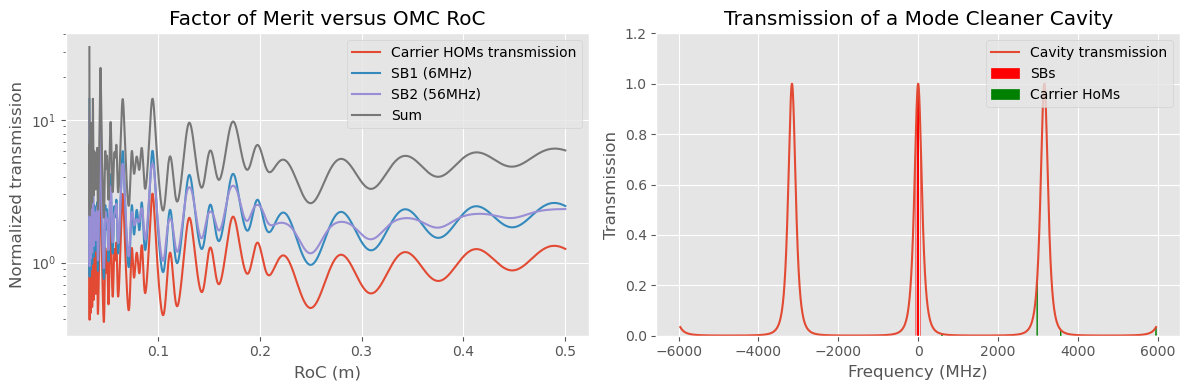

In [14]:
# Cavity transmission

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1.plot(rho_vect, T_HOMs_vect_car, label='Carrier HOMs transmission')
ax1.plot(rho_vect, T_HOMs_vect_SB[0], label='SB1 (6MHz)')
ax1.plot(rho_vect, T_HOMs_vect_SB[1], label='SB2 (56MHz)')
ax1.plot(rho_vect, T_HOMs_vect_sum, label='Sum')
ax1.set_xlabel('RoC (m)')
ax1.set_ylabel('Normalized transmission')
ax1.set_yscale('log')
ax1.set_title('Factor of Merit versus OMC RoC')
ax1.legend()


MCdf.plot_transmission(Lgeo, Fomc, Ideal_RoC, fm, 10, ax2)

# Display the subplots
plt.tight_layout()
plt.show()

In [15]:
# Cavity characteristics

T_HOMs = T_HOMs_vect_sum_filtered[min_index_filtered] # Get the minimum T_HOMs from the filtered T_HOMs_vect_sum
Mirror_angle=MCdf.mirror_angle(cavity_dim[0][0], cavity_dim[1][0]) # Compute the mirrors angle in radian
astigmatism_losses=MCdf.astigmatism_losses(Mirror_angle, Ideal_RoC, Lgeo) * 1e6 # Calculate astigmatism losses
print("HOMs transmission (W)=", T_HOMs)
print("Mirror angle (°)=", np.rad2deg(Mirror_angle), ", losses (ppm)=", astigmatism_losses)

waist = MCdf.waist_size(Lgeo, Ideal_RoC, lambda_)
print("Waist size (μm):", waist*1e6)

P_input = 1.0  # Input power in Watts
max_pwr = MCdf.circ_power(P_input, waist)
print("Circ power (MW/m²):", max_pwr/1e6)


HOMs transmission (W)= 2.3135472784859616
Mirror angle (°)= 12.91049598709464 , losses (ppm)= 1255.42200401499
Waist size (μm): 334.8766156620377
Circ power (MW/m²): 8.917237960108155


We can specify the error bars for the manufacturer if we zoom around this value.

Progress: 100.00%
Calculation done.


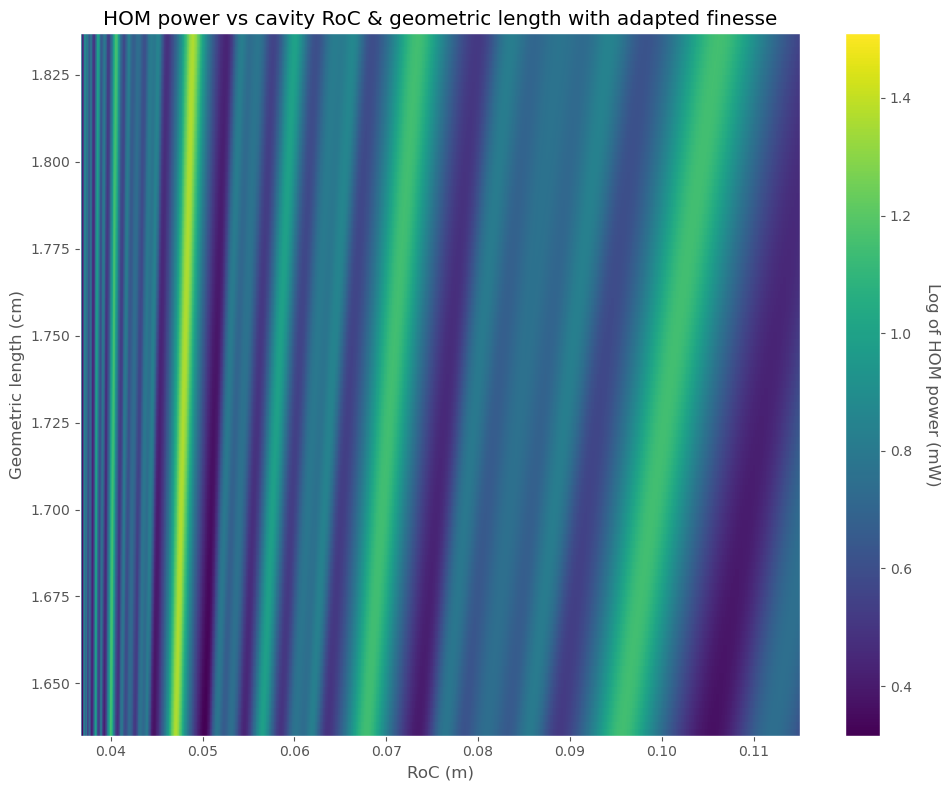

In [17]:
# Heatmap of the HOMs transmissions

# Create a grid of geometric lengths
Lgeo_vect = np.linspace(Lgeo-0.001, Lgeo+0.001, 101) # cm

# Initialize T_HOMs matrices for carrier and SBs
T_HOMs_mat_car = np.zeros((len(Lgeo_vect), 1001))
T_HOMs_mat_SB = np.zeros((len(Lgeo_vect), 1001))

# Loop over geometric lengths and calculate T_HOMs
for j, Lgeo in enumerate(Lgeo_vect):
    # Determine the max finesse that respect SB_limit
    FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
    Lopt=2*idxn*Lgeo
    Fomc = FLopt_max / Lopt
    rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB = MCdf.THOMvsRoC(Lgeo, Fomc, Ideal_RoC+0.01, fm, P_HOMs, 1001)
    T_HOMs_mat_car[j, :] = T_HOMs_vect_car
    T_HOMs_mat_SB[j, :] = T_HOMs_vect_SB[0]+T_HOMs_vect_SB[1] # Transpose the result to match dimensions
    
    # Print percentage of completion
    sys.stdout.write("\rProgress: {0:.2f}%".format((j+1)/len(Lgeo_vect)*100))
    sys.stdout.flush()

# After the loop
print("\nCalculation done.")

# Plot the heatmaps
plt.figure(figsize=(10, 8))

c1 = plt.pcolormesh(rho_vect, Lgeo_vect*100, np.log10(T_HOMs_mat_car+T_HOMs_mat_SB), cmap='viridis')
plt.xlabel('RoC (m)')
plt.ylabel('Geometric length (cm)')
plt.title('HOM power vs cavity RoC & geometric length with adapted finesse')
colorbar=plt.colorbar(c1)
colorbar.set_label('Log of HOM power (mW)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()